In [79]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

In [80]:
def xml_to_df(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    # Define namespace (if required)
    namespace = {"ns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"}
    
    # Prepare a list to hold data
    data = []
    
    # Iterate through each TimeSeries
    for ts in root.findall("ns:TimeSeries", namespace):
        ts_id = ts.find("ns:mRID", namespace).text
        business_type = ts.find("ns:businessType", namespace).text
        aggregation = ts.find("ns:objectAggregation", namespace).text
        bidding_zone = ts.find("ns:outBiddingZone_Domain.mRID", namespace).text
        unit = ts.find("ns:quantity_Measure_Unit.name", namespace).text
    
        # Iterate through periods
        for period in ts.findall("ns:Period", namespace):
            start_time = period.find("ns:timeInterval/ns:start", namespace).text
            end_time = period.find("ns:timeInterval/ns:end", namespace).text
            resolution = period.find("ns:resolution", namespace).text
    
            # Iterate through points
            for point in period.findall("ns:Point", namespace):
                position = int(point.find("ns:position", namespace).text)
                quantity = float(point.find("ns:quantity", namespace).text)
    
                # Append to data list
                data.append([ts_id, business_type, aggregation, bidding_zone, unit, start_time, end_time, resolution, position, quantity])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=[
        "TimeSeries_ID", "BusinessType", "Aggregation", "BiddingZone", "Unit",
        "StartTime", "EndTime", "Resolution", "Position", "Quantity"
    ])

    return df

<Axes: >

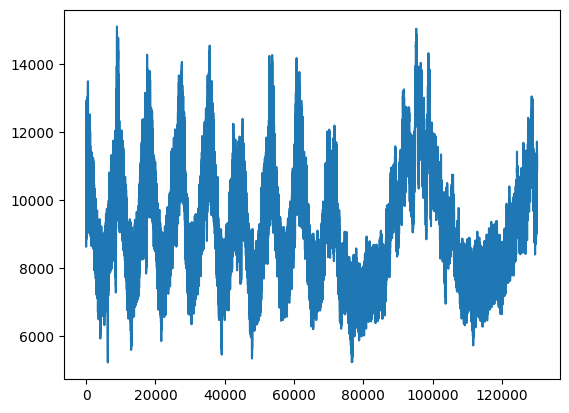

In [93]:
# Combine the years to a single dataframe.
years = list(range(2015, 2025))
df = pd.DataFrame()

for year in years:
    xml_file = f"../data/actual-load-data/finland/ACTUAL_TOTAL_LOAD_{year}01010000-{year + 1}01010000.xml"

    df = pd.concat([df, xml_to_df(xml_file)], ignore_index=True)
    
df['Quantity'].plot()

In [109]:
# Average the 15M resolution to 1H to keep data uniform.

print(df)

df_15m = df[df['Resolution'] == 'PT15M'].copy()
df_60m = df[df['Resolution'] == 'PT60M']

df_15m['Group'] = df_15m.index // 4
df_15m_avg = df_15m.groupby('Group').agg({
    'StartTime' : 'first',
    'EndTime' : 'first',
    'TimeSeries_ID' : 'first',
    'BusinessType' : 'first',
    'Aggregation' : 'first',
    'BiddingZone' : 'first',
    'Unit' : 'first',
    'Position' : 'first',
    'Resolution' : lambda x: 'PT60M',
    'Quantity': 'mean'
}).reset_index(drop=True)

df_hourly = pd.concat([df_15m_avg, df_60m]).sort_values(by=['StartTime', 'Position']).reset_index(drop=True)

# Convert StartTime to datetime
df_hourly['StartTime'] = pd.to_datetime(df_hourly['StartTime'])

# Create a datetime index by adding 'Position' as hours offset from StartTime
df_hourly['Datetime'] = df_hourly['StartTime'] + pd.to_timedelta(df_hourly['Position'] - 1, unit='h')

# Set Datetime as the index
df_hourly.set_index('Datetime', inplace=True)

print(df_hourly)

       TimeSeries_ID BusinessType Aggregation       BiddingZone Unit  \
0                  1          A04         A01  10YFI-1--------U  MAW   
1                  1          A04         A01  10YFI-1--------U  MAW   
2                  1          A04         A01  10YFI-1--------U  MAW   
3                  1          A04         A01  10YFI-1--------U  MAW   
4                  1          A04         A01  10YFI-1--------U  MAW   
...              ...          ...         ...               ...  ...   
130151           366          A04         A01  10YFI-1--------U  MAW   
130152           366          A04         A01  10YFI-1--------U  MAW   
130153           366          A04         A01  10YFI-1--------U  MAW   
130154           366          A04         A01  10YFI-1--------U  MAW   
130155           366          A04         A01  10YFI-1--------U  MAW   

                StartTime            EndTime Resolution  Position  Quantity  
0       2014-12-31T23:00Z  2015-01-01T23:00Z      PT60M  

<Axes: xlabel='Datetime'>

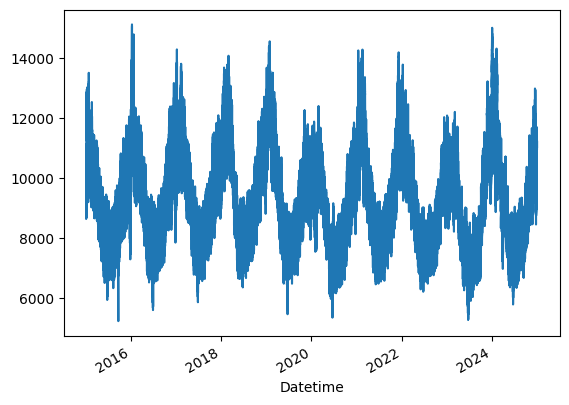

In [110]:
df_hourly['Quantity'].plot()

In [111]:
df_hourly.to_csv("../data/actual-load-data/finland/ACTUAL_TOTAL_LOAD_201501010000-202501010000.csv")